In [20]:

import os
import shutil
import time
from collections import defaultdict


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from SALib.analyze import sobol


from ema_workbench import (
    Model, Policy, Scenario, MultiprocessingEvaluator,
    ema_logging
)
from ema_workbench.analysis import (
    feature_scoring, parcoords, pairs_plotting, prim
)
from ema_workbench.em_framework.evaluators import (
    BaseEvaluator, perform_experiments
)
from ema_workbench.em_framework.optimization import (
    ArchiveLogger, EpsilonProgress, EpsNSGAII,
    HyperVolume, epsilon_nondominated, to_problem
)
from ema_workbench.em_framework.outcomes import ScalarOutcome
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.em_framework.samplers import sample_uncertainties
from pandas.api.types import is_numeric_dtype



from problem_formulation import get_model_for_problem_formulation
from ema_workbench.analysis import dimensional_stacking
from pandas.api.types import is_numeric_dtype, is_categorical_dtype

def get_do_nothing_dict():
    return {l.name: 0 for l in model.levers}





In [21]:
#Start with running baseline scenario
if __name__ == "__main__":
    model, _ = get_model_for_problem_formulation(3)

    with MultiprocessingEvaluator(model, n_processes=-1) as evaluator:
        baseline = Policy("do_nothing", **get_do_nothing_dict())
        policies = [baseline]

        results = evaluator.perform_experiments(scenarios=1000, policies=policies)
        baseline_experiments, baseline_outcomes = results


INFO | pool started with 7 workers
INFO | performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
100%|██████████████████████████████████████| 1000/1000 [02:39<00:00,  6.26it/s]
INFO | experiments finished
INFO | terminating pool


## Running and showing the model

In [22]:
if __name__ == "__main__":

    # --- Load your model ---
    model, planning_steps = get_model_for_problem_formulation(3)



    reference_values = {
        "Bmax": 175,
        "Brate": 1.5,
        "pfail": 0.5,
        "discount rate 0": 3.5,
        "discount rate 1": 3.5,
        "discount rate 2": 3.5,
        "ID flood wave shape": 4,
    }
    scen1 = {}

    for key in model.uncertainties:
        name_split = key.name.split("_")

        if len(name_split) == 1:
            scen1.update({key.name: reference_values[key.name]})

        else:
            scen1.update({key.name: reference_values[name_split[1]]})

    ref_scenario = Scenario("reference", **scen1)


    convergence_metrics = [

    EpsilonProgress(),
]

    espilon = [0.01] * len(model.outcomes)


    nfe = 15000

    with MultiprocessingEvaluator(model) as evaluator:
        results, convergence = evaluator.optimize(
            nfe=nfe,
            searchover="levers",
            epsilons=espilon,
            convergence=convergence_metrics, reference=ref_scenario,

        )

INFO | pool started with 8 workers
  0%|                                                  | 0/100 [00:00<?, ?it/s]INFO | EpsNSGAII starting
INFO | EpsNSGAII finished; Total NFE: 100, Elapsed Time: 0:00:15.397875
100%|████████████████████████████████████████| 100/100 [00:15<00:00,  6.49it/s]
INFO | optimization completed, found 15 solutions
INFO | terminating pool


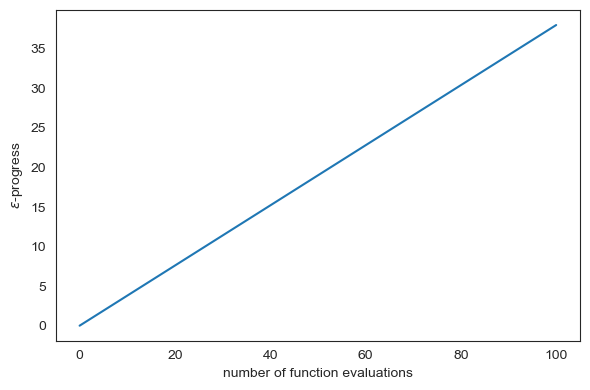

In [23]:
fig, ax1 = plt.subplots(figsize=(6, 4))  # no ncols=2

ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel(r'$\epsilon$-progress')
ax1.set_xlabel('number of function evaluations')
plt.savefig("convergence enkel MORDM.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()



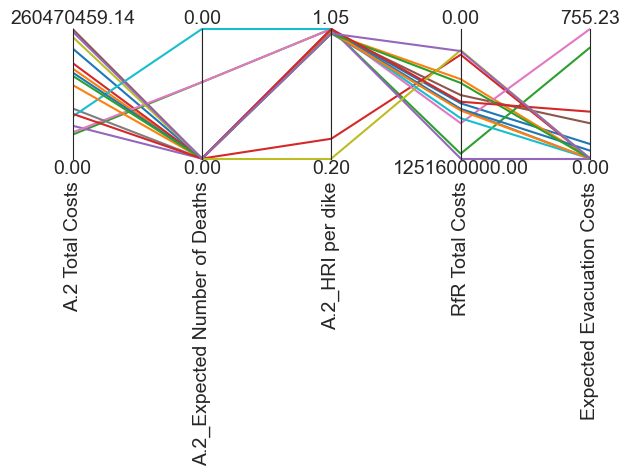

<Figure size 1400x1000 with 0 Axes>

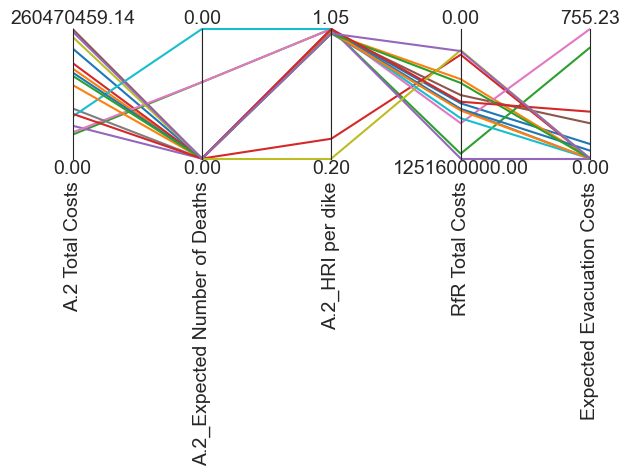

In [24]:
data = results.loc[:, [o.name for o in model.outcomes]]
limits = parcoords.get_limits(data)
limits.loc[0, ['A.2 Total Costs', 'A.2_Expected Number of Deaths', 'RfR Total Costs',"Expected Evacuation Costs"]] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis("RfR Total Costs")
    # Set larger figure size (wider and taller)
plt.figure(figsize=(14, 10))  # width=12 inches, height=8 inches

# Generate parallel axes with your limits
paraxes = parcoords.ParallelAxes(limits)

# Plot the data
paraxes.plot(data)

# Invert specific axis
paraxes.invert_axis("RfR Total Costs")

# Save the plot
plt.savefig("mordm_parallel coordinates all.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [25]:
logical = (
    (results["A.2 Total Costs"] < 7e7) &

    (results["A.2_HRI per dike"] > 0.7))



np.sum(logical)

3

/var/folders/b_/nlpf2cxd39n843m6xybwrynh0000gn/T/ipykernel_93559/959764074.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_1["policy"] = results_1.index  # Automatically uses 16, 17, 18 in your case


<Figure size 1400x1000 with 0 Axes>

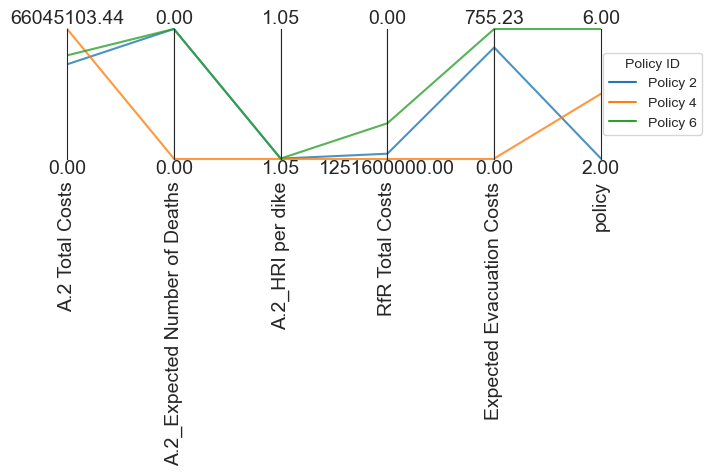

In [26]:
results_1 = results[logical]
results_1["policy"] = results_1.index  # Automatically uses 16, 17, 18 in your case


data = results_1.loc[:, [o.name for o in model.outcomes] + ['policy']]


limits = parcoords.get_limits(data)
limits.loc[0, ['A.2 Total Costs', 'A.2_Expected Number of Deaths',
               'RfR Total Costs', 'Expected Evacuation Costs']] = 0


policy_ids = data["policy"].unique()
colors = sns.color_palette("tab10", len(policy_ids))
color_map = dict(zip(policy_ids, colors))


plt.figure(figsize=(14, 10))
paraxes = parcoords.ParallelAxes(limits)

# Plot each policy row with its assigned color
for _, row in data.iterrows():
    policy_id = row["policy"]
    color = color_map.get(policy_id, "gray")
    paraxes.plot(row.to_frame().T, color=color, alpha=0.8)

# Invert axis if needed
paraxes.invert_axis("RfR Total Costs")

from matplotlib.lines import Line2D
legend_handles = [
    Line2D([0], [0], color=color_map[pid], label=f"Policy {pid}")
    for pid in policy_ids
]
plt.legend(handles=legend_handles, title="Policy ID", loc="center left",bbox_to_anchor=(1.02, 0.5),borderaxespad=0)


plt.savefig("parallel_coords_MORDM_selected_policies.png", dpi=300, bbox_inches='tight')
plt.show()

## optimized policies

In [27]:
policies = results[logical]
policies = policies.drop([o.name for o in model.outcomes], axis=1)
policies

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
2,1,1,1,0,0,0,0,1,1,1,...,0,8,10,0,4,9,9,8,4,6
4,0,0,0,1,1,0,1,1,0,1,...,0,9,6,7,6,0,9,3,3,1
6,1,1,1,0,0,1,1,0,1,1,...,0,1,1,7,6,0,0,8,6,4


In [28]:
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

In [29]:
#Create policy dataframe
lever_names = [l.name for l in model.levers]
policies_df = results[lever_names]
policies_df.to_csv("candidate_policies.csv", index=False)

## Testing out the policies

In [30]:
n_scenarios = 1000
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)

INFO | pool started with 8 workers
INFO | performing 1000 scenarios * 3 policies * 1 model(s) = 3000 experiments
 25%|█████████▌                             | 737/3000 [01:56<06:21,  5.93it/s]INFO | terminating pool
Process SpawnPoolWorker-41:
Process SpawnPoolWorker-43:
Process SpawnPoolWorker-39:
Process SpawnPoolWorker-46:
Process SpawnPoolWorker-40:
Process SpawnPoolWorker-42:
Traceback (most recent call last):
Process SpawnPoolWorker-44:
Traceback (most recent call last):
  File "/Users/tessahuysinga/Downloads/anaconda3/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/tessahuysinga/Downloads/anaconda3/lib/python3.12/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/tessahuysinga/Downloads/anaconda3/lib/python3.12/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/tessahuysinga/Downloads/

KeyboardInterrupt: 

In [12]:
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    if std==0:
        std = 1

    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std


In [13]:
experiments, outcomes = results

overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}

    logical = experiments['policy']==policy

    for outcome in model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,A.2 Total Costs,A.2_Expected Number of Deaths,A.2_HRI per dike,Expected Evacuation Costs,RfR Total Costs
8,1.205650e+16,0.008506,1.783125,0.0,92100000.0


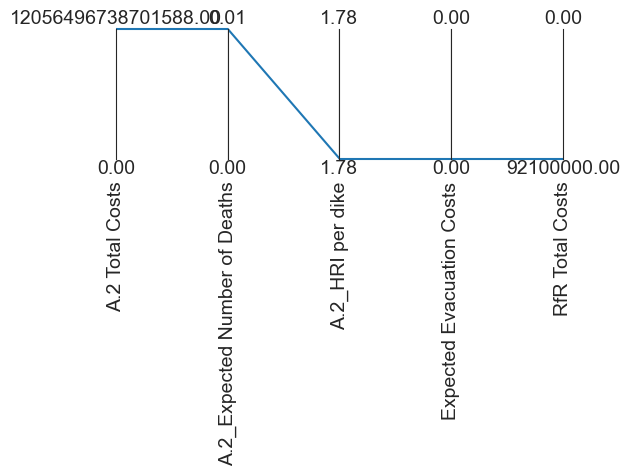

<Figure size 1400x1000 with 0 Axes>

In [14]:
data = scores
limits = parcoords.get_limits(data)
limits.loc[0, ['A.2 Total Costs', 'A.2_Expected Number of Deaths', 'RfR Total Costs',"Expected Evacuation Costs"]] = 0


paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis("RfR Total Costs")
plt.figure(figsize=(14, 10))
plt.savefig("scores_single_MORDM.png", dpi=300, bbox_inches='tight') # width=12 inches, height=8 inches
plt.show()

In [15]:
def calculate_regret(data, best):
    return np.abs(best-data)

In [16]:
experiments, outcomes = results

overall_regret = {}
max_regret = {}
for outcome in model.outcomes:
    policy_column = experiments['policy']

    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name],
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})

    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')

    # flatten the resulting hierarchical index resulting from
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)

    # we need to control the broadcasting.
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across
    # the row and the actual values in the row
    #
    outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()

    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

/Users/tessahuysinga/Downloads/anaconda3/lib/python3.12/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/tessahuysinga/Downloads/anaconda3/lib/python3.12/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


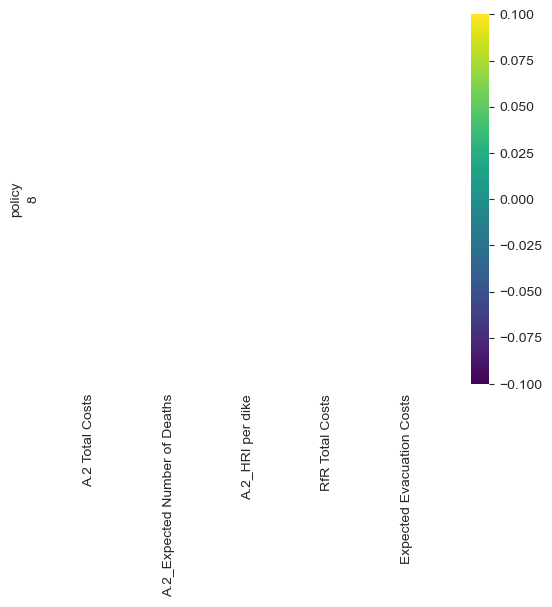

In [17]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.savefig("regret_single_MORDM.png", dpi=300, bbox_inches='tight')
plt.show()

In [18]:

policy_regret = defaultdict(dict)
for key, value in overall_regret.items():
    for policy in value:
        policy_regret[policy][key] = value[policy]

UnboundLocalError: cannot access local variable 'boxprops' where it is not associated with a value

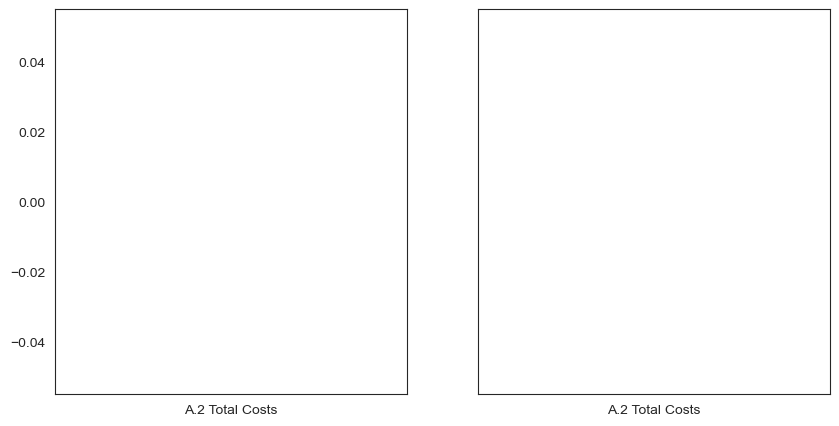

In [19]:
# this generates a 2 plots with a shared y and x axis
fig, axes = plt.subplots(ncols=2, figsize=(10,5),
                         sharey=True, sharex=True)

# to ensure easy iteration over the axes grid, we turn it
# into a list. Because there are four plots, I hard coded
# this.


# zip allows us to zip together the list of axes and the list of
# key value pairs return by items. If we iterate over this
# it returns a tuple of length 2. The first item is the ax
# the second items is the key value pair.
for ax, (policy, regret) in zip(axes, policy_regret.items()):
    data = pd.DataFrame(regret)

    # we need to scale the regret to ensure fair visual
    # comparison. We can do that by divding by the maximum regret
    data = data/max_regret.max(axis=0)
    sns.boxplot(data=data, ax=ax)

    # removes top and left hand black outline of axes
    sns.despine()

    # ensure we know which policy the figure is for
    ax.set_title(str(policy))
plt.show()

## Selecteren scenarios maar gaan we doen met PRIM

In [20]:
policies_df = pd.read_csv("candidate_policies.csv")

# zet elke rij om in een Policy-object
candidate_policies = [
    Policy(f"cand_{i}", **row.to_dict())
    for i, row in policies_df.iterrows()

    ]

In [21]:
if __name__ == "__main__":
    model, _ = get_model_for_problem_formulation(3)
    scenarios=1000
    #policies=4
    with MultiprocessingEvaluator(model, n_processes=-1) as evaluator:
        results = evaluator.perform_experiments(scenarios=scenarios, policies=candidate_policies )

        experiments, outcomes = results

INFO | pool started with 7 workers
INFO | performing 1000 scenarios * 6 policies * 1 model(s) = 6000 experiments
100%|██████████████████████████████████████| 6000/6000 [06:56<00:00, 14.42it/s]
INFO | experiments finished
INFO | terminating pool


In [22]:
hri_sys = outcomes["A.2_HRI per dike"]
hri_q25 = np.percentile(hri_sys, 25)# (N,) systeembreed
target_hri = hri_sys <= hri_q25

        # ---- 2.2 Expected Annual Damage ----
ead_total = outcomes["A.2 Total Costs"] # (N,)
ead_q75 = np.percentile(ead_total, 75)
target_ead = ead_total >= ead_q75

        # # ---- 2.3 RfR Total Costs ----
        # rfr_costs = outcomes["RfR Total Costs"].sum(axis=1)  # (N,)
        # rfr_q75 = np.percentile(rfr_costs, 75)
        # target_rfr = rfr_costs >= rfr_q75

        # ---- 2.4 Combineer tot één worst-case target ----
y = target_hri | target_ead        # booleaanse vector (N,)


# hri_baseline=baseline_outcomes["A.2_HRI per dike"]
# hri_sys = outcomes["A.2_HRI per dike"]
# hri_q25 = np.percentile(hri_baseline, 25)# (N,) systeembreed
# target_hri = hri_sys <= hri_q25
#
#         # ---- 2.2 Expected Annual Damage ----
# cost_baseline=baseline_outcomes["A.2 Total Costs"]
# cost_total = outcomes["A.2 Total Costs"] # (N,)
# cost_q75 = np.percentile(cost_baseline, 75)
# target_cost = cost_total >= cost_q75

        # # ---- 2.3 RfR Total Costs ----
        # rfr_costs = outcomes["RfR Total Costs"].sum(axis=1)  # (N,)
        # rfr_q75 = np.percentile(rfr_costs, 75)
        # target_rfr = rfr_costs >= rfr_q75

#         # ---- 2.4 Combineer tot één worst-case target ----
# y = target_hri | target_cost
# y

print(f"worst-cases: {y.sum()} van {n_scenarios*policies} runs  ({y.mean()*100:.1f} %)")

        # Determine model uncertainties
cols_unc = [u.name for u in model.uncertainties]
X = experiments[cols_unc]

#Start PRIM
prim_alg = prim.Prim(
            X, y,
            threshold=0.80,
        )

print("Aantal opgeslagen boxen:", len(prim_alg.boxes))

worst-cases: 2244 van    0_RfR 0  0_RfR 1  0_RfR 2  1_RfR 0  1_RfR 1  1_RfR 2  2_RfR 0  2_RfR 1  \
0        0        0        0        0        0        0     1000     1000   
1        0        0        0        0        0        0     1000     1000   
5        0        0        0        0        0        0     1000     1000   

   2_RfR 2  3_RfR 0  ...  A.2_DikeIncrease 2  A.3_DikeIncrease 0  \
0     1000     1000  ...                   0                6000   
1     1000        0  ...                   0                9000   
5     1000     1000  ...                   0                5000   

   A.3_DikeIncrease 1  A.3_DikeIncrease 2  A.4_DikeIncrease 0  \
0               10000                1000                6000   
1                7000                6000                1000   
5                   0                2000                5000   

   A.4_DikeIncrease 1  A.4_DikeIncrease 2  A.5_DikeIncrease 0  \
0                7000                1000                3000   
1    

INFO | 6000 points remaining, containing 2244 cases of interest
INFO | mean: 1.0, mass: 0.108, coverage: 0.2887700534759358, density: 1.0 restricted_dimensions: 2


coverage      0.28877
density       1.00000
id           42.00000
k           648.00000
mass          0.10800
mean          1.00000
n           648.00000
res_dim       2.00000
Name: 42, dtype: float64

             box 42                                       
                min       max      qp value       qp value
A.2_pfail  0.000317  0.223260           NaN  4.867268e-220
A.1_pfail  0.470456  0.999023  2.102025e-68            NaN



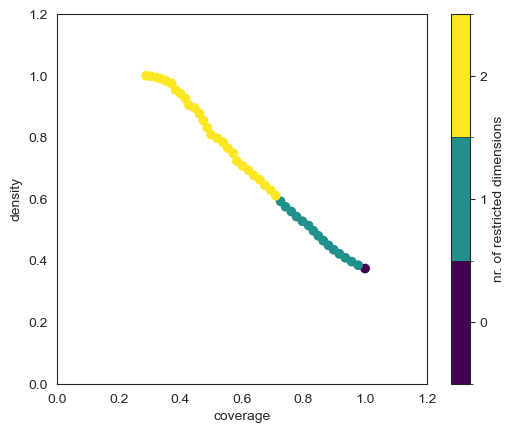

43 stappen in deze box


In [23]:
# A) De “beste” box volgens je threshold
box = prim_alg.find_box()
box.inspect()
box.show_tradeoff()
plt.show()# geeft een PrimBox terug
traj = box.peeling_trajectory
print(len(traj), "stappen in deze box")

[<Figure size 640x480 with 1 Axes>]

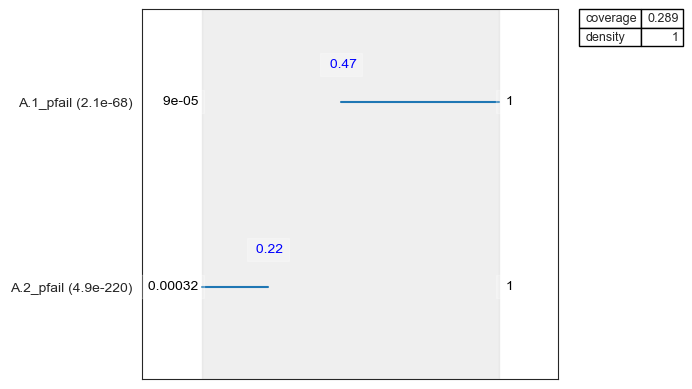

In [24]:
# en inspecteer 'm meteen
box.inspect( style="graph" )

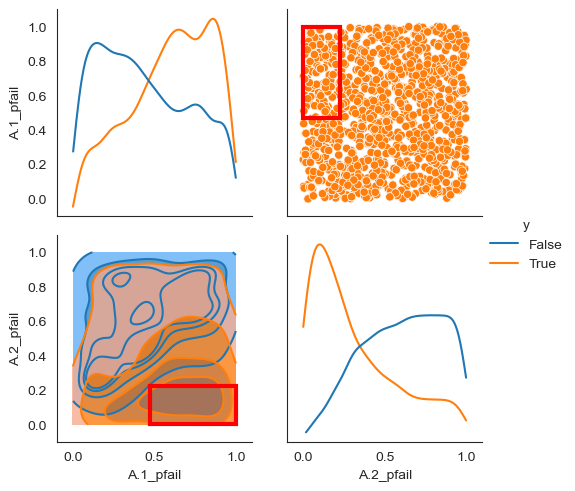

In [25]:
fig = box.show_pairs_scatter()
plt.show()

INFO | model dropped from analysis because only a single category


origineel aantal kolommen: 53
zonder levers           : 22


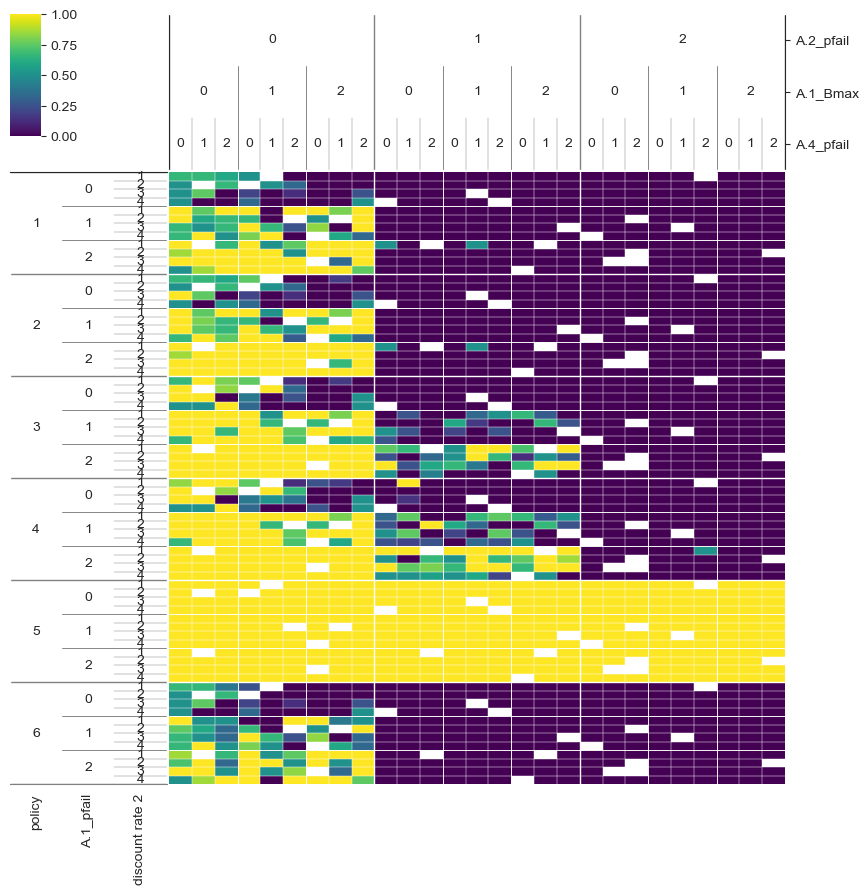

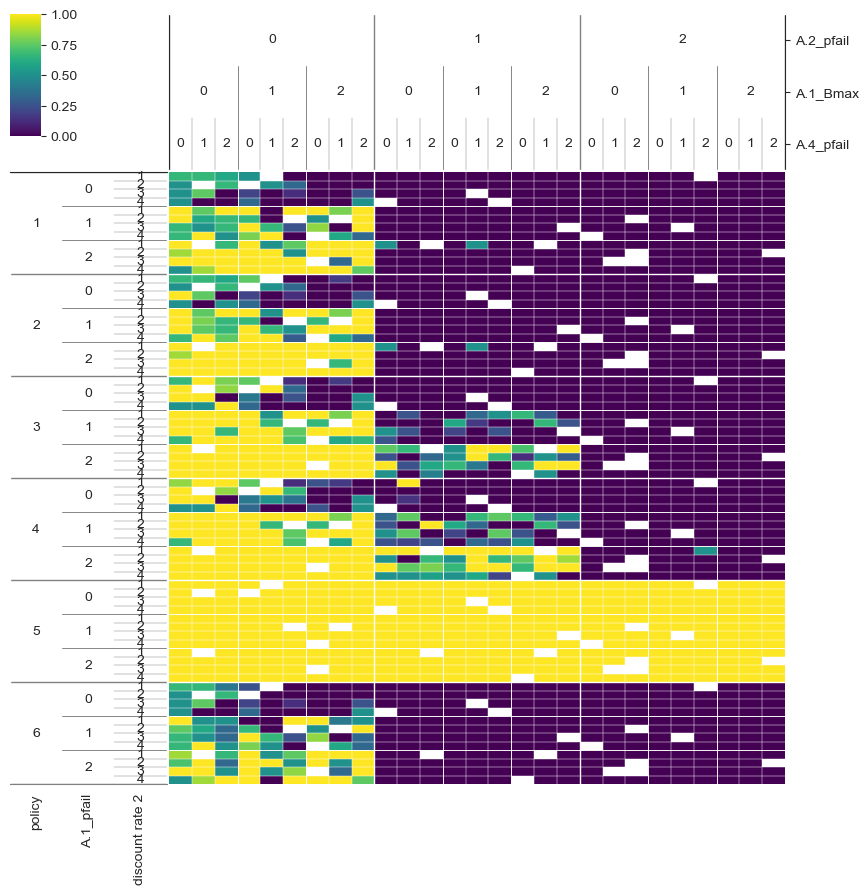

In [26]:
lever_names = [lev.name for lev in model.levers]
experiments_unc = experiments.drop(columns=lever_names)


# even checken:
print("origineel aantal kolommen:", experiments.shape[1])
print("zonder levers           :", experiments_unc.shape[1])

dimensional_stacking.create_pivot_plot(experiments_unc, y)


In [27]:

# 1) Haal de grenzen op uit de box (list met één entry per box in je peeling_trajectory)
raw_limits = box.box_lims[0]

# 1) Transponeren, zodat elke var een rij wordt, en de kolommen 0 en 1 zijn
df_lim = raw_limits.T

# 2) Hernoemen van de kolommen 0→min en 1→max
df_lim = df_lim.rename(columns={0: "min", 1: "max"})

# 3) (optioneel) zet de index-naam netjes
df_lim.index.name = "var"

In [28]:
df_lim
mask = pd.Series(True, index=experiments.index)

for var, row in df_lim.iterrows():
    lo, hi = row["min"], row["max"]
    ser = experiments[var]

    if is_numeric_dtype(ser):
        # voor numerieke parameters
        mask &= ser.between(lo, hi)
    else:
        # voor categorische parameters
        # lo kan een set/list zijn, of een enkele waarde
        if isinstance(lo, (set, list)):
            mask &= ser.isin(lo)
        else:
            mask &= (ser == lo)

exp_in_box = experiments[mask]
out_in_box = {
    name: array[mask.values]  # .values is een numpy‐boolean array
    for name, array in outcomes.items()
}

In [29]:
expanded = {}
for name, arr in out_in_box.items():
    if arr.ndim == 1:
        # gewoon een vector
        expanded[name] = arr
    else:
        # maak per tijdstap een kolom
        T = arr.shape[1]
        for t in range(T):
            expanded[f"{name}_{t}"] = arr[:, t]

out_df = pd.DataFrame(expanded)

In [30]:
exp_in_box['worst_case']=y[exp_in_box.index]
true_worst= exp_in_box[exp_in_box['worst_case']]
#
# true_worst = true_worst.assign(
#     total_cost = out_in_box['A.2 Total Costs']
# )

In [31]:
# --- 1) Maak één Series van alle total costs, met de originele index ---
all_costs = pd.Series(
    out_in_box['A.2 Total Costs'],       # numpy array voor _alle_ runs in out_in_box
    index = exp_in_box.index              # die hoort dezelfde lengte en index labels te hebben
)

# --- 2) Filter die Series naar alleen de worst‐case subset (true_worst.index) ---
worst_costs = all_costs.loc[true_worst.index]

# --- 3) Wijs die gefilterde Series toe als nieuwe kolom ---
true_worst = true_worst.assign(total_costs=worst_costs)

In [32]:
true_worst['total_costs'] = pd.Series(
    out_in_box['A.2 Total Costs'],
    index=exp_in_box.index
).loc[true_worst.index]

In [33]:
true_worst

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model,worst_case,total_costs
5,16,143.839469,1.5,0.518317,271.155768,1.5,0.144114,104.836401,10.0,0.259530,...,7,1,3,6,2,2005,cand_0,dikesnet,True,1.216332e+08
9,82,128.468297,1.5,0.257833,157.110098,1.5,0.013333,116.621438,1.0,0.500190,...,7,1,3,6,2,2009,cand_0,dikesnet,True,3.398718e+08
11,86,174.527143,10.0,0.580938,326.830080,1.0,0.028291,330.309053,1.5,0.009530,...,7,1,3,6,2,2011,cand_0,dikesnet,True,7.142993e+08
28,69,179.607995,1.0,0.645307,107.765941,10.0,0.135961,50.699257,1.5,0.165333,...,7,1,3,6,2,2028,cand_0,dikesnet,True,1.619695e+08
37,3,334.350720,1.5,0.506312,129.927260,1.5,0.134397,287.447442,1.5,0.959773,...,7,1,3,6,2,2037,cand_0,dikesnet,True,1.635170e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5967,19,186.024409,10.0,0.821573,195.773871,1.5,0.109137,292.473734,1.0,0.051427,...,3,0,3,1,5,2967,cand_5,dikesnet,True,2.384964e+08
5971,25,289.379585,1.0,0.829331,226.931142,1.0,0.137270,181.440285,1.0,0.153048,...,3,0,3,1,5,2971,cand_5,dikesnet,True,1.447962e+08
5978,73,50.978002,1.5,0.105929,345.833749,1.5,0.095671,329.464147,10.0,0.693705,...,3,0,3,1,5,2978,cand_5,dikesnet,True,1.053738e+08
5990,83,121.082141,10.0,0.753783,59.230558,1.5,0.106156,97.977775,10.0,0.881916,...,3,0,3,1,5,2990,cand_5,dikesnet,True,2.191471e+08


In [34]:
# --- 1) Maak één Series van alle total costs, met de originele index ---
all_costs = pd.Series(
    out_in_box['A.2_HRI per dike'],       # numpy array voor _alle_ runs in out_in_box
    index = exp_in_box.index              # die hoort dezelfde lengte en index labels te hebben
)

# --- 2) Filter die Series naar alleen de worst‐case subset (true_worst.index) ---
worst_HRI = all_costs.loc[true_worst.index]

# --- 3) Wijs die gefilterde Series toe als nieuwe kolom ---
true_worst = true_worst.assign(HRI=worst_HRI)

In [35]:
true_worst

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model,worst_case,total_costs,HRI
5,16,143.839469,1.5,0.518317,271.155768,1.5,0.144114,104.836401,10.0,0.259530,...,1,3,6,2,2005,cand_0,dikesnet,True,1.216332e+08,0.05
9,82,128.468297,1.5,0.257833,157.110098,1.5,0.013333,116.621438,1.0,0.500190,...,1,3,6,2,2009,cand_0,dikesnet,True,3.398718e+08,0.05
11,86,174.527143,10.0,0.580938,326.830080,1.0,0.028291,330.309053,1.5,0.009530,...,1,3,6,2,2011,cand_0,dikesnet,True,7.142993e+08,0.05
28,69,179.607995,1.0,0.645307,107.765941,10.0,0.135961,50.699257,1.5,0.165333,...,1,3,6,2,2028,cand_0,dikesnet,True,1.619695e+08,0.05
37,3,334.350720,1.5,0.506312,129.927260,1.5,0.134397,287.447442,1.5,0.959773,...,1,3,6,2,2037,cand_0,dikesnet,True,1.635170e+08,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5967,19,186.024409,10.0,0.821573,195.773871,1.5,0.109137,292.473734,1.0,0.051427,...,0,3,1,5,2967,cand_5,dikesnet,True,2.384964e+08,0.05
5971,25,289.379585,1.0,0.829331,226.931142,1.0,0.137270,181.440285,1.0,0.153048,...,0,3,1,5,2971,cand_5,dikesnet,True,1.447962e+08,0.05
5978,73,50.978002,1.5,0.105929,345.833749,1.5,0.095671,329.464147,10.0,0.693705,...,0,3,1,5,2978,cand_5,dikesnet,True,1.053738e+08,0.05
5990,83,121.082141,10.0,0.753783,59.230558,1.5,0.106156,97.977775,10.0,0.881916,...,0,3,1,5,2990,cand_5,dikesnet,True,2.191471e+08,0.05


In [36]:
# 1) min-max schaal HRI en costs
hri = true_worst['HRI']
cost = true_worst['total_costs']

hri_scaled = (hri - hri.min()) / (hri.max() - hri.min())
cost_scaled = (cost - cost.min()) / (cost.max() - cost.min())

# 2) keer de costs om
inv_cost = 1 - cost_scaled

# 3) bereken de samengestelde score
score = hri_scaled * inv_cost

# 4) voeg toe aan true_worst
true_worst = true_worst.assign(
    hri_scaled = hri_scaled,
    cost_scaled = cost_scaled,
    inv_cost    = inv_cost,
    score       = score
)

true_worst.head()

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,scenario,policy,model,worst_case,total_costs,HRI,hri_scaled,cost_scaled,inv_cost,score
5,16,143.839469,1.5,0.518317,271.155768,1.5,0.144114,104.836401,10.0,0.259530,...,2005,cand_0,dikesnet,True,1.216332e+08,0.05,1.0,0.081927,0.918073,0.918073
9,82,128.468297,1.5,0.257833,157.110098,1.5,0.013333,116.621438,1.0,0.500190,...,2009,cand_0,dikesnet,True,3.398718e+08,0.05,1.0,0.260510,0.739490,0.739490
11,86,174.527143,10.0,0.580938,326.830080,1.0,0.028291,330.309053,1.5,0.009530,...,2011,cand_0,dikesnet,True,7.142993e+08,0.05,1.0,0.566900,0.433100,0.433100
28,69,179.607995,1.0,0.645307,107.765941,10.0,0.135961,50.699257,1.5,0.165333,...,2028,cand_0,dikesnet,True,1.619695e+08,0.05,1.0,0.114934,0.885066,0.885066
37,3,334.350720,1.5,0.506312,129.927260,1.5,0.134397,287.447442,1.5,0.959773,...,2037,cand_0,dikesnet,True,1.635170e+08,0.05,1.0,0.116200,0.883800,0.883800


In [37]:
# # 1) voeg y als kolom toe
# exp_in_box = exp_in_box.copy()
# exp_in_box['worst_case'] = y[exp_in_box.index]
#
# # 2) houd alleen echte worst-cases over
# true_worst = exp_in_box[exp_in_box['worst_case']]

# 3) kies uit true_worst je max/min/median voor EAD & HRI
best  = true_worst.nlargest(1, 'score')   #best case is hoogste
worst = true_worst.nsmallest(1,  'score')      #worst case is laagste
mid   = true_worst.iloc[[len(true_worst)//2]]

In [38]:
# 1) knijp de rij samen naar een Series
best_s   = best.iloc[0]  # of .iloc[0]
mid_s = mid.iloc[0]
worst_s  = worst.iloc[0]



df_scenarios = pd.DataFrame([
    best_s.to_dict(),
    mid_s.to_dict(),
    worst_s.to_dict()
], index=["best_case", "median_case", "worst_case"])

df_scenarios = (
    df_scenarios
    .rename(columns={"scenario.1": "scenario"})  # als hij zo heet
    .set_index("scenario")                        # zet de kolom als index
)

In [39]:
df_scenarios

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.5_DikeIncrease 2,policy,model,worst_case,total_costs,HRI,hri_scaled,cost_scaled,inv_cost,score
scenario,,,,,,,,,,,,,,,,,,,,,
2921,129,62.938276,10.0,0.887053,99.721500,10.0,0.317094,73.535388,10.0,0.703719,...,5,cand_1,dikesnet,True,4.575341e+07,0.05,1.000000,0.019836,0.980164,0.980164
2038,120,162.950592,1.5,0.191712,76.409081,1.0,0.333009,229.420122,10.0,0.230527,...,5,cand_4,dikesnet,True,4.281842e+07,0.00,0.952381,0.017434,0.982566,0.935777
2722,8,88.924471,1.5,0.868250,118.206807,10.0,0.031628,176.274592,1.5,0.407207,...,6,cand_3,dikesnet,True,1.243573e+09,-0.60,0.380952,1.000000,0.000000,0.000000


In [40]:
df_scenarios.to_csv("reference_scenarios.csv", index_label="scenario")


In [41]:
candidate_scenarios = [
    Scenario(f"scenario_{idx}", **row.to_dict())
    for idx, row in df_scenarios.iterrows()
]

In [42]:
for scenario in candidate_scenarios:
    print(scenario)

Scenario({'A.0_ID flood wave shape': 129, 'A.1_Bmax': 62.93827558941081, 'A.1_Brate': 10.0, 'A.1_pfail': 0.8870527867048901, 'A.2_Bmax': 99.72150007065837, 'A.2_Brate': 10.0, 'A.2_pfail': 0.3170942436517222, 'A.3_Bmax': 73.53538794787856, 'A.3_Brate': 10.0, 'A.3_pfail': 0.703718630954556, 'A.4_Bmax': 208.7372799029493, 'A.4_Brate': 10.0, 'A.4_pfail': 0.6705429656002171, 'A.5_Bmax': 117.56980900629864, 'A.5_Brate': 10.0, 'A.5_pfail': 0.8858229191980191, 'discount rate 0': 2.5, 'discount rate 1': 1.5, 'discount rate 2': 1.5, '0_RfR 0': 0, '0_RfR 1': 0, '0_RfR 2': 0, '1_RfR 0': 0, '1_RfR 1': 0, '1_RfR 2': 0, '2_RfR 0': 1, '2_RfR 1': 1, '2_RfR 2': 1, '3_RfR 0': 0, '3_RfR 1': 0, '3_RfR 2': 0, '4_RfR 0': 0, '4_RfR 1': 0, '4_RfR 2': 0, 'EWS_DaysToThreat': 0, 'A.1_DikeIncrease 0': 0, 'A.1_DikeIncrease 1': 0, 'A.1_DikeIncrease 2': 0, 'A.2_DikeIncrease 0': 0, 'A.2_DikeIncrease 1': 0, 'A.2_DikeIncrease 2': 0, 'A.3_DikeIncrease 0': 9, 'A.3_DikeIncrease 1': 7, 'A.3_DikeIncrease 2': 6, 'A.4_DikeIncr

## scenario's uit PRIM

In [43]:
# df_scenarios= pd.read_csv('reference_scenarios.csv')
#
# df_scenarios = (
#     df_scenarios
#     .rename(columns={"scenario.1": "scenario"})
#     .set_index("scenario")            )

In [44]:
# df_scenarios=df_scenarios[cols_unc]
# df_scenarios

In [45]:
    # candidate_scenarios = [
    #     Scenario(f"scenario_{idx}", **row.to_dict())
    #     for idx, row in df_scenarios.iterrows()
    # ]

## vanaf hier wordt het multi MORDM

In [46]:

ema_logging.log_to_stderr(ema_logging.INFO)


<Logger EMA (DEBUG)>

In [ ]:
from ema_workbench import MultiprocessingEvaluator, ema_logging
from ema_workbench.em_framework.optimization import EpsilonProgress
from ema_workbench.em_framework.optimization import to_problem
import pandas as pd

ema_logging.log_to_stderr(ema_logging.INFO)


nfe = 15000
epsilons = [0.01] * len(model.outcomes)

results = []
convergence_records = []

with MultiprocessingEvaluator(model) as evaluator:
    for i, scenario in enumerate(candidate_scenarios[:3]):
        #for seed in range(3):
        print(f"🔄 Running: Scenario {i} ({scenario.name}) ")

        eps_prog = EpsilonProgress()
        result, convergence = evaluator.optimize(
                nfe=nfe,
                searchover="levers",
                epsilons=epsilons,
                convergence=[eps_prog],
                reference=scenario,
            )

            # Store optimization results
        results.append(pd.DataFrame(result))

            # The convergence object is a DataFrame already
        convergence_df = pd.DataFrame(convergence)
        convergence_df["scenario"] = scenario.name
        #convergence_df["seed"] = seed
        convergence_records.append(convergence_df)

# Merge final dataframes
combined_results = pd.concat(results, ignore_index=True)
convergence_df = pd.concat(convergence_records, ignore_index=True)

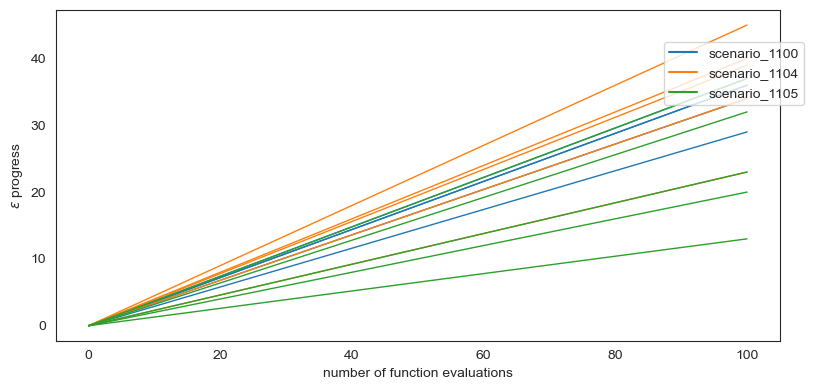

In [125]:
# === PLOT ε-PROGRESS BY SCENARIO ===
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(8, 4))
colors = sns.color_palette()
legend_items = []

for (scenario_name, scores), color in zip(convergence_df.groupby("scenario"), colors):
    # Create custom legend item
    legend_items.append((mpl.lines.Line2D([0, 0], [1, 1], c=color), scenario_name))

    # Plot each seed
    for seed, score in scores.groupby("seed"):
        ax.plot(score.nfe, score.epsilon_progress, c=color, lw=1)

ax.set_ylabel(r'$\epsilon$ progress')
ax.set_xlabel('number of function evaluations')

# Add legend
artists, labels = zip(*legend_items)
fig.legend(artists, labels, bbox_to_anchor=(1.02, 0.9))

plt.tight_layout()
plt.savefig("convergence_multi_mordm.png", dpi=300, bbox_inches='tight')
plt.show()

In [127]:
combined_results

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,A.2 Total Costs,A.2_Expected Number of Deaths,A.2_HRI per dike,RfR Total Costs,Expected Evacuation Costs
0,1,0,0,0,0,0,1,1,0,0,...,2,9,10,10,10,2.246601e+08,0.000000,0.65,4.021000e+08,0.000000
1,0,0,1,1,1,0,0,0,1,0,...,0,0,5,6,10,2.122973e+08,0.000191,0.99,5.509000e+08,116.042716
2,1,0,0,1,0,1,0,1,1,1,...,4,7,5,0,2,1.511781e+08,0.000000,1.01,9.589000e+08,0.000000
3,1,1,0,1,0,0,0,1,0,0,...,1,4,3,5,6,8.127741e+07,0.000000,0.75,9.299000e+08,0.000000
4,1,0,0,0,1,0,0,1,1,1,...,8,0,10,10,9,1.208922e+08,0.000000,1.05,9.835000e+08,18.130066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,0,1,0,0,0,0,1,0,0,0,...,6,10,4,10,10,1.921435e+08,0.000899,1.00,4.926000e+08,268.285082
230,1,1,1,0,0,0,1,0,1,1,...,3,6,9,3,7,2.206829e+08,0.000000,0.99,6.925000e+08,0.000000
231,0,0,0,1,1,0,1,0,0,0,...,9,10,4,2,6,2.745843e+08,0.024265,1.04,5.875000e+08,16154.611874
232,1,0,1,0,0,0,1,1,1,1,...,3,2,7,1,3,1.367129e+08,0.102754,1.05,8.810000e+08,0.000000


In [128]:
print(combined_results)

     0_RfR 0  0_RfR 1  0_RfR 2  1_RfR 0  1_RfR 1  1_RfR 2  2_RfR 0  2_RfR 1  \
0          1        0        0        0        0        0        1        1   
1          0        0        1        1        1        0        0        0   
2          1        0        0        1        0        1        0        1   
3          1        1        0        1        0        0        0        1   
4          1        0        0        0        1        0        0        1   
..       ...      ...      ...      ...      ...      ...      ...      ...   
229        0        1        0        0        0        0        1        0   
230        1        1        1        0        0        0        1        0   
231        0        0        0        1        1        0        1        0   
232        1        0        1        0        0        0        1        1   
233        0        0        0        0        1        1        1        0   

     2_RfR 2  3_RfR 0  ...  A.4_DikeIncrease 1  A.4

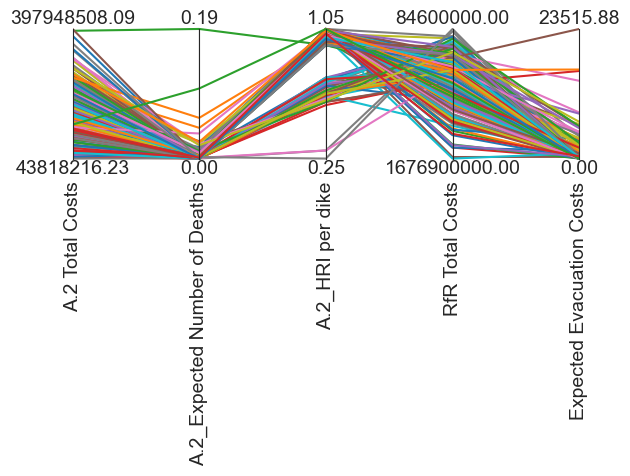

<Figure size 1400x1000 with 0 Axes>

In [129]:
data = combined_results.loc[:, [o.name for o in model.outcomes]]
limits = parcoords.get_limits(data)

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis("RfR Total Costs")
    # Set larger figure size (wider and taller)
plt.figure(figsize=(14, 10))
plt.savefig("multi mordm all.png", dpi=300, bbox_inches='tight') # width=12 inches, height=8 inches


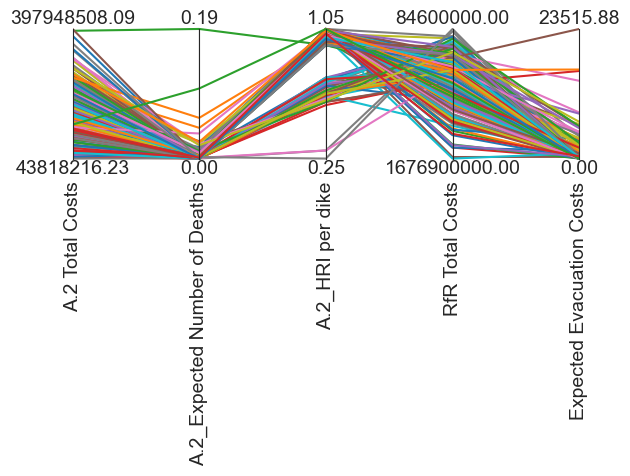

In [130]:

# Generate parallel axes with your limits
paraxes = parcoords.ParallelAxes(limits)

# Plot the data
paraxes.plot(data)

# Invert specific axis
paraxes.invert_axis("RfR Total Costs")

# Save the plot
plt.savefig("mordm_parallel_coordinates.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [131]:



logical = (
    (combined_results["A.2 Total Costs"] < 7e7) &

    (combined_results["A.2_HRI per dike"] > 1))



np.sum(logical)
combined_results[logical]

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,A.2 Total Costs,A.2_Expected Number of Deaths,A.2_HRI per dike,RfR Total Costs,Expected Evacuation Costs
16,1,1,1,1,0,1,0,0,1,0,...,4,1,4,5,2,5.941010e+07,0.000000,1.05,8.413000e+08,158.053117
17,1,1,0,0,1,0,1,0,1,0,...,3,0,2,5,4,5.941010e+07,0.000000,1.05,1.203000e+09,0.000000
30,1,1,1,0,0,1,0,1,1,0,...,0,2,3,9,6,6.599780e+07,0.004790,1.05,7.891000e+08,0.000000
32,1,0,0,0,1,1,1,1,0,1,...,5,10,0,2,7,5.335857e+07,0.000000,1.05,1.336200e+09,167.866812
33,1,0,1,1,0,1,1,1,0,1,...,6,2,9,1,7,6.336577e+07,0.000429,1.05,1.542000e+09,129.143736
35,1,0,0,1,1,1,0,0,1,0,...,9,8,2,2,1,5.448080e+07,0.000583,1.05,1.658200e+09,312.773519
53,0,0,0,1,0,1,0,0,1,1,...,7,1,4,0,10,4.713819e+07,0.000870,1.05,1.086000e+09,467.956605
54,0,0,0,1,0,0,0,1,1,1,...,3,0,7,9,1,5.335857e+07,0.000000,1.05,1.033800e+09,10.980003
73,1,1,0,1,1,1,0,0,1,0,...,10,10,3,4,1,6.628434e+07,0.001824,1.01,9.745000e+08,1634.778081
83,0,1,0,1,0,1,0,0,1,0,...,9,1,8,9,4,4.784270e+07,0.000000,1.05,1.184300e+09,0.000000


/var/folders/b_/nlpf2cxd39n843m6xybwrynh0000gn/T/ipykernel_68771/2740734344.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_2["policy"] = results_2.index  # Automatically uses 16, 17, 18 in your case


<Figure size 1400x1000 with 0 Axes>

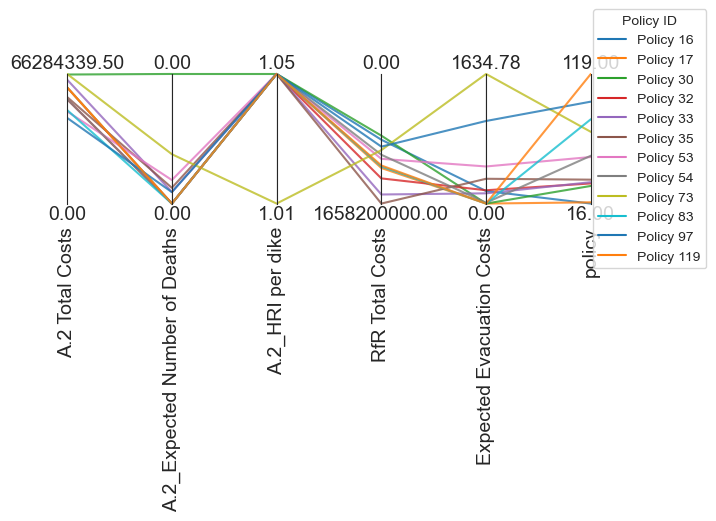

In [132]:

results_2 = combined_results[logical]
results_2["policy"] = results_2.index  # Automatically uses 16, 17, 18 in your case


data = results_2.loc[:, [o.name for o in model.outcomes] + ['policy']]


limits = parcoords.get_limits(data)
limits.loc[0, ['A.2 Total Costs', 'A.2_Expected Number of Deaths',
               'RfR Total Costs', 'Expected Evacuation Costs']] = 0


policy_ids = data["policy"].unique()
colors = sns.color_palette("tab10", len(policy_ids))
color_map = dict(zip(policy_ids, colors))


plt.figure(figsize=(14, 10))
paraxes = parcoords.ParallelAxes(limits)

# Plot each policy row with its assigned color
for _, row in data.iterrows():
    policy_id = row["policy"]
    color = color_map.get(policy_id, "gray")
    paraxes.plot(row.to_frame().T, color=color, alpha=0.8)

# Invert axis if needed
paraxes.invert_axis("RfR Total Costs")


legend_handles = [
    Line2D([0], [0], color=color_map[pid], label=f"Policy {pid}")
    for pid in policy_ids
]
plt.legend(handles=legend_handles, title="Policy ID", loc="center left",bbox_to_anchor=(1.02, 0.5),borderaxespad=0)


plt.savefig("parallel_coords_multi_MORDM_selected_policies.png", dpi=300, bbox_inches='tight')
plt.show()

In [133]:
policies = combined_results[logical]
policies = policies.drop([o.name for o in model.outcomes], axis=1)
policies

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
16,1,1,1,1,0,1,0,0,1,0,...,0,2,4,9,2,4,1,4,5,2
17,1,1,0,0,1,0,1,0,1,0,...,0,1,1,4,10,3,0,2,5,4
30,1,1,1,0,0,1,0,1,1,0,...,0,10,2,2,0,0,2,3,9,6
32,1,0,0,0,1,1,1,1,0,1,...,0,1,3,2,1,5,10,0,2,7
33,1,0,1,1,0,1,1,1,0,1,...,0,1,2,1,6,6,2,9,1,7
35,1,0,0,1,1,1,0,0,1,0,...,0,5,5,2,10,9,8,2,2,1
53,0,0,0,1,0,1,0,0,1,1,...,0,3,10,1,7,7,1,4,0,10
54,0,0,0,1,0,0,0,1,1,1,...,0,5,4,3,3,3,0,7,9,1
73,1,1,0,1,1,1,0,0,1,0,...,4,7,0,10,9,10,10,3,4,1
83,0,1,0,1,0,1,0,0,1,0,...,0,3,0,5,1,9,1,8,9,4


In [134]:
test=combined_results[logical]
test

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,A.2 Total Costs,A.2_Expected Number of Deaths,A.2_HRI per dike,RfR Total Costs,Expected Evacuation Costs
16,1,1,1,1,0,1,0,0,1,0,...,4,1,4,5,2,5.941010e+07,0.000000,1.05,8.413000e+08,158.053117
17,1,1,0,0,1,0,1,0,1,0,...,3,0,2,5,4,5.941010e+07,0.000000,1.05,1.203000e+09,0.000000
30,1,1,1,0,0,1,0,1,1,0,...,0,2,3,9,6,6.599780e+07,0.004790,1.05,7.891000e+08,0.000000
32,1,0,0,0,1,1,1,1,0,1,...,5,10,0,2,7,5.335857e+07,0.000000,1.05,1.336200e+09,167.866812
33,1,0,1,1,0,1,1,1,0,1,...,6,2,9,1,7,6.336577e+07,0.000429,1.05,1.542000e+09,129.143736
35,1,0,0,1,1,1,0,0,1,0,...,9,8,2,2,1,5.448080e+07,0.000583,1.05,1.658200e+09,312.773519
53,0,0,0,1,0,1,0,0,1,1,...,7,1,4,0,10,4.713819e+07,0.000870,1.05,1.086000e+09,467.956605
54,0,0,0,1,0,0,0,1,1,1,...,3,0,7,9,1,5.335857e+07,0.000000,1.05,1.033800e+09,10.980003
73,1,1,0,1,1,1,0,0,1,0,...,10,10,3,4,1,6.628434e+07,0.001824,1.01,9.745000e+08,1634.778081
83,0,1,0,1,0,1,0,0,1,0,...,9,1,8,9,4,4.784270e+07,0.000000,1.05,1.184300e+09,0.000000


## Hier onder worden de policies gemaakt die getest moeten worden

In [135]:

policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

In [90]:
n_scenarios = 1000
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)

[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 100 scenarios * 12 policies * 1 model(s) = 1200 experiments
100%|██████████████████████████████████████| 1200/1200 [00:59<00:00, 20.16it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [91]:
results

(      A.0_ID flood wave shape    A.1_Bmax A.1_Brate  A.1_pfail    A.2_Bmax  \
 0                         119  339.144779       1.5   0.970113  123.091681   
 1                          69   89.863700       1.5   0.055591   77.795405   
 2                         106  100.800168       1.5   0.697398  203.179903   
 3                          97  268.559443       1.0   0.758802  165.059490   
 4                           4  159.435584       1.5   0.236918  344.653473   
 ...                       ...         ...       ...        ...         ...   
 1195                       37  275.853237       1.0   0.825705  269.015415   
 1196                       77  277.525774       1.5   0.884571  153.613644   
 1197                       85   71.510335      10.0   0.684853   68.993082   
 1198                       11  133.880284       1.5   0.854920   91.253891   
 1199                      122  328.302719       1.0   0.409545  252.665693   
 
      A.2_Brate  A.2_pfail    A.3_Bmax A.3_Brate  

In [92]:
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    if std==0:
        std = 1

    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std


In [93]:
from ema_workbench import ScalarOutcome

experiments, outcomes = results

overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}

    logical = experiments['policy']==policy

    for outcome in model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,A.2 Total Costs,A.2_Expected Number of Deaths,A.2_HRI per dike,RfR Total Costs,Expected Evacuation Costs
119,8.415098e+14,1.396433e-06,5.154135,1.170600e+09,1.068522e+06
16,1.138924e+15,1.460162e-05,4.588315,8.413000e+08,3.166504e+06
17,6.530373e+14,8.495743e-07,5.154135,1.203000e+09,9.805300e+06
30,7.547267e+15,2.284869e-03,5.154135,7.891000e+08,0.000000e+00
32,1.358714e+15,3.975617e-06,4.168652,1.336200e+09,1.334011e+07
33,5.304213e+15,2.903859e-05,5.154135,1.542000e+09,1.002802e+07
35,1.233876e+16,8.139139e-05,2.427674,1.658200e+09,5.496180e+07
53,1.753105e+16,1.349527e-04,1.437500,1.086000e+09,6.533992e+07
54,1.352455e+15,2.215844e-05,4.168652,1.033800e+09,2.486796e+06
73,2.110058e+16,1.518050e-04,2.876412,9.745000e+08,6.858924e+07


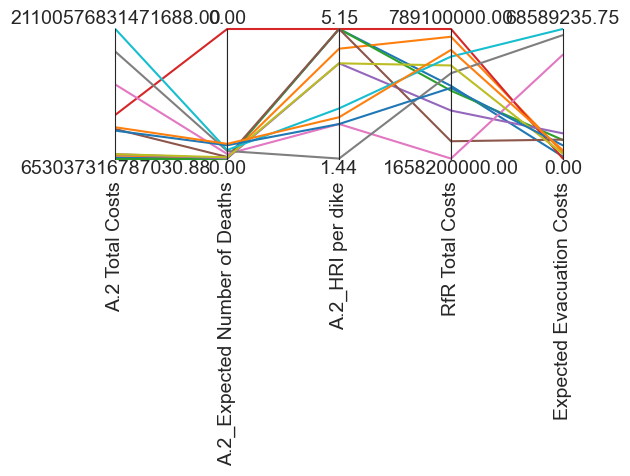

In [94]:
data = scores
limits = parcoords.get_limits(data)


paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis("RfR Total Costs")

plt.show()

In [95]:
experiments, outcomes = results

overall_regret = {}
max_regret = {}
for outcome in model.outcomes:
    policy_column = experiments['policy']

    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name],
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})

    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')

    # flatten the resulting hierarchical index resulting from
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)

    # we need to control the broadcasting.
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across
    # the row and the actual values in the row
    #
    outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()

    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

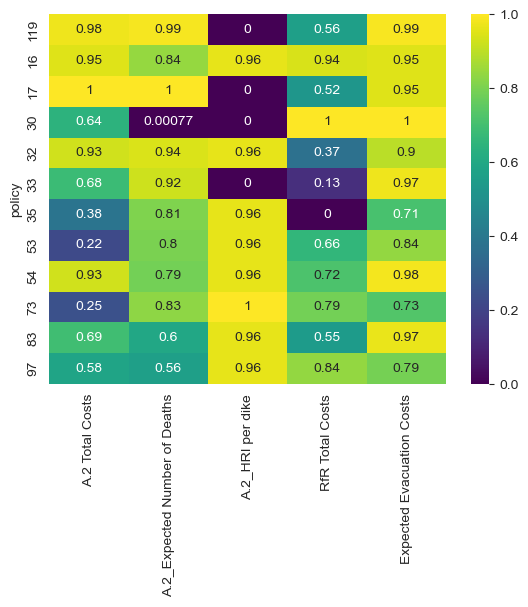

In [96]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.savefig("regret multi mordm.png", dpi=300, bbox_inches='tight')
plt.show()

In [97]:
experiments

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model
0,119,339.144779,1.5,0.970113,123.091681,1.0,0.152285,230.792175,10.0,0.903443,...,9,2,4,1,4,5,2,1110,16,dikesnet
1,69,89.863700,1.5,0.055591,77.795405,1.5,0.757736,179.938248,10.0,0.442036,...,9,2,4,1,4,5,2,1111,16,dikesnet
2,106,100.800168,1.5,0.697398,203.179903,1.0,0.674892,35.285715,1.5,0.899409,...,9,2,4,1,4,5,2,1112,16,dikesnet
3,97,268.559443,1.0,0.758802,165.059490,1.5,0.910285,322.458056,1.5,0.049431,...,9,2,4,1,4,5,2,1113,16,dikesnet
4,4,159.435584,1.5,0.236918,344.653473,1.5,0.301819,172.390876,1.5,0.866585,...,9,2,4,1,4,5,2,1114,16,dikesnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,37,275.853237,1.0,0.825705,269.015415,1.5,0.632107,250.474541,1.0,0.166649,...,6,7,3,10,9,5,4,1205,119,dikesnet
1196,77,277.525774,1.5,0.884571,153.613644,10.0,0.807077,180.464008,10.0,0.579925,...,6,7,3,10,9,5,4,1206,119,dikesnet
1197,85,71.510335,10.0,0.684853,68.993082,10.0,0.799969,110.776858,10.0,0.666943,...,6,7,3,10,9,5,4,1207,119,dikesnet
1198,11,133.880284,1.5,0.854920,91.253891,1.5,0.407834,348.968895,1.0,0.878025,...,6,7,3,10,9,5,4,1208,119,dikesnet


In [98]:
policies

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
16,1,1,1,1,0,1,0,0,1,0,...,0,2,4,9,2,4,1,4,5,2
17,1,1,0,0,1,0,1,0,1,0,...,0,1,1,4,10,3,0,2,5,4
30,1,1,1,0,0,1,0,1,1,0,...,0,10,2,2,0,0,2,3,9,6
32,1,0,0,0,1,1,1,1,0,1,...,0,1,3,2,1,5,10,0,2,7
33,1,0,1,1,0,1,1,1,0,1,...,0,1,2,1,6,6,2,9,1,7
35,1,0,0,1,1,1,0,0,1,0,...,0,5,5,2,10,9,8,2,2,1
53,0,0,0,1,0,1,0,0,1,1,...,0,3,10,1,7,7,1,4,0,10
54,0,0,0,1,0,0,0,1,1,1,...,0,5,4,3,3,3,0,7,9,1
73,1,1,0,1,1,1,0,0,1,0,...,4,7,0,10,9,10,10,3,4,1
83,0,1,0,1,0,1,0,0,1,0,...,0,3,0,5,1,9,1,8,9,4


In [99]:
policies.to_csv("multi-scenario_policies.csv", index=True)


## PRIM analyse met multi scenario policies voor robustness

In [100]:
# lees de CSV in met de gevonden policies vanuit de MORDM
policies_multiscenario = pd.read_csv("multi-scenario_policies.csv")

# zet elke rij om in een Policy-object
multiscenario_policies = [
    Policy(f"cand_{i}", **row.to_dict())
    for i, row in policies_multiscenario.iterrows()

    ]


In [105]:
if __name__ == "__main__":
    model, _ = get_model_for_problem_formulation(3)

    df_pols = pd.read_csv("multi-scenario_policies.csv")

    # policies = [
    #     Policy(f"policy_{i}", **row.to_dict())
    #     for i, row in df_pols.iterrows()
    # ]

    scenarios=1000
    policies=multiscenario_policies #policies retrieved from multi scenario MORDM
    with MultiprocessingEvaluator(model, n_processes=-1) as evaluator:
        results = evaluator.perform_experiments(scenarios=scenarios, policies=policies )

        experiments, outcomes = results

[MainProcess/INFO] pool started with 7 workers
[MainProcess/INFO] performing 100 scenarios * 12 policies * 1 model(s) = 1200 experiments
100%|██████████████████████████████████████| 1200/1200 [01:00<00:00, 19.92it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [106]:
experiments

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model
0,15,325.824226,1.5,0.359544,341.996505,1.5,0.485857,82.156465,10.0,0.966369,...,9,2,4,1,4,5,2,2210,cand_0,dikesnet
1,104,307.118082,1.5,0.202314,278.550533,1.0,0.841676,126.860418,10.0,0.691645,...,9,2,4,1,4,5,2,2211,cand_0,dikesnet
2,108,160.598780,1.0,0.061213,158.728471,1.5,0.720967,214.946591,1.5,0.411908,...,9,2,4,1,4,5,2,2212,cand_0,dikesnet
3,13,245.615345,10.0,0.801942,324.763187,10.0,0.875777,225.204971,1.0,0.521247,...,9,2,4,1,4,5,2,2213,cand_0,dikesnet
4,63,175.526792,1.5,0.194889,225.728283,1.5,0.450965,320.373138,1.5,0.326590,...,9,2,4,1,4,5,2,2214,cand_0,dikesnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,46,193.525669,10.0,0.850605,55.000346,10.0,0.045662,336.857276,1.5,0.465480,...,6,7,3,10,9,5,4,2305,cand_11,dikesnet
1196,69,87.856424,10.0,0.476110,51.898910,1.0,0.600759,264.822742,10.0,0.708239,...,6,7,3,10,9,5,4,2306,cand_11,dikesnet
1197,117,79.818682,1.5,0.295756,139.825558,10.0,0.988539,112.808815,1.5,0.052191,...,6,7,3,10,9,5,4,2307,cand_11,dikesnet
1198,122,289.080021,1.0,0.935358,199.662417,1.0,0.031186,149.508140,1.5,0.807981,...,6,7,3,10,9,5,4,2308,cand_11,dikesnet


In [107]:
results_per_policy = {}

hri_baseline=baseline_outcomes["A.2_HRI per dike"]
hri_sys = outcomes["A.2_HRI per dike"]
hri_q25 = np.percentile(hri_baseline, 25)# (N,) systeembreed
target_hri = hri_sys <= hri_q25

        # ---- 2.2 Expected Annual Damage ----
cost_baseline=baseline_outcomes["A.2 Total Costs"]
cost_total = outcomes["A.2 Total Costs"] # (N,)
cost_q75 = np.percentile(cost_baseline, 75)
target_cost = cost_total >= cost_q75

        # # ---- 2.3 RfR Total Costs ----
        # rfr_costs = outcomes["RfR Total Costs"].sum(axis=1)  # (N,)
        # rfr_q75 = np.percentile(rfr_costs, 75)
        # target_rfr = rfr_costs >= rfr_q75

        # ---- 2.4 Combineer tot één worst-case target ----
y = target_hri | target_cost
y


array([False, False, False, ..., False, False, False])

In [108]:
for pol in multiscenario_policies:

    pol_name = pol.name

    # selecteer alleen de runs met exact die naam
    mask_pol = experiments["policy"] == pol_name
    X_pol   = experiments.loc[mask_pol, [u.name for u in model.uncertainties]]
    y_pol   = y[mask_pol]

    # 3) sanity‐checks
    # 3) sanity‐checks
    print(f"Policy {pol.name!r}: {len(X_pol)} runs (y=True: {y_pol.sum()}, y=False: {len(y_pol)-y_pol.sum()})")

    if len(X_pol) == 0:
        print("  → geen runs met deze policy, overslaan")
        continue

    if not (y_pol.dtype == bool):
        y_pol = y_pol.astype(bool)

    if y_pol.sum() == 0 or y_pol.sum() == len(y_pol):
        print("  → y bevat niet zowel True als False, overslaan")
        continue

    # 2) maak en run PRIM
    prim_alg = prim.Prim(
        X_pol,
        y_pol,
        threshold=0.6,       # kies zelf je cover‐of‐density cut‐off
        peel_alpha=0.05,     # hoe “agressief” peel je
        mass_min=0.1        # minimale fractie runs in box
    )
    box = prim_alg.find_box()

    box.inspect()
    #box.show_tradeoff()

    traj = box.peeling_trajectory


    # 3) bewaar je result voor latere vergelijking
    results_per_policy[pol_name] = {
        "prim_alg":   prim_alg,
        "selected_box": box,
        "trajectory":   traj,
    }
        # "box_id": int(traj.score.idxmax())

[MainProcess/INFO] 100 points remaining, containing 2 cases of interest


Policy 'cand_0': 100 runs (y=True: 2, y=False: 98)


[MainProcess/INFO] box mean (0.13333333333333333) does not meet threshold criteria (1 0.6),returning dump box
[MainProcess/INFO] 100 points remaining, containing 1 cases of interest
[MainProcess/INFO] box mean (0.058823529411764705) does not meet threshold criteria (1 0.6),returning dump box
[MainProcess/INFO] 100 points remaining, containing 12 cases of interest


coverage      1.00
density       0.02
id            0.00
k             2.00
mass          1.00
mean          0.02
n           100.00
res_dim       0.00
Name: 0, dtype: float64

Empty DataFrame
Columns: [(box 0, min), (box 0, max), (box 0, qp value), (box 0, qp value)]
Index: []

Policy 'cand_1': 100 runs (y=True: 1, y=False: 99)
coverage      1.00
density       0.01
id            0.00
k             1.00
mass          1.00
mean          0.01
n           100.00
res_dim       0.00
Name: 0, dtype: float64

Empty DataFrame
Columns: [(box 0, min), (box 0, max), (box 0, qp value), (box 0, qp value)]
Index: []

Policy 'cand_2': 100 runs (y=True: 12, y=False: 88)


[MainProcess/INFO] mean: 1.0, mass: 0.11, coverage: 0.9166666666666666, density: 1.0 restricted_dimensions: 3
/Users/tessahuysinga/Downloads/anaconda3/lib/python3.12/site-packages/ema_workbench/analysis/prim.py:501: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '{2.5, 4.5}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  box_lim.loc[unc] = values.values.tolist() + qp_values[unc]
[MainProcess/INFO] 100 points remaining, containing 2 cases of interest
[MainProcess/INFO] box mean (0.13333333333333333) does not meet threshold criteria (1 0.6),returning dump box
[MainProcess/INFO] 100 points remaining, containing 10 cases of interest


coverage     0.916667
density      1.000000
id          24.000000
k           11.000000
mass         0.110000
mean         1.000000
n           11.000000
res_dim      3.000000
Name: 24, dtype: float64

                     box 24                                   
                        min         max qp value      qp value
A.2_pfail          0.006511    0.119516      NaN  1.862009e-07
discount rate 2  {2.5, 4.5}  {2.5, 4.5}      1.0           NaN
A.1_Bmax          62.818899  349.393941      1.0           NaN

Policy 'cand_3': 100 runs (y=True: 2, y=False: 98)
coverage      1.00
density       0.02
id            0.00
k             2.00
mass          1.00
mean          0.02
n           100.00
res_dim       0.00
Name: 0, dtype: float64

Empty DataFrame
Columns: [(box 0, min), (box 0, max), (box 0, qp value), (box 0, qp value)]
Index: []

Policy 'cand_4': 100 runs (y=True: 10, y=False: 90)


[MainProcess/INFO] mean: 0.6363636363636364, mass: 0.11, coverage: 0.7, density: 0.6363636363636364 restricted_dimensions: 7
/Users/tessahuysinga/Downloads/anaconda3/lib/python3.12/site-packages/ema_workbench/analysis/prim.py:501: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '{10.0, 1.0}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  box_lim.loc[unc] = values.values.tolist() + qp_values[unc]
[MainProcess/INFO] 100 points remaining, containing 16 cases of interest


coverage     0.700000
density      0.636364
id          12.000000
k            7.000000
mass         0.110000
mean         0.636364
n           11.000000
res_dim      7.000000
Name: 12, dtype: float64

                          box 12                                     
                             min              max  qp value  qp value
A.2_pfail               0.006511          0.76744       NaN  0.204521
A.2_Brate            {10.0, 1.0}      {10.0, 1.0}  0.065567       NaN
A.5_Brate            {1.0, 10.0}      {1.0, 10.0}  0.110926       NaN
A.3_Brate             {1.5, 1.0}       {1.5, 1.0}  0.114493       NaN
discount rate 2  {1.5, 2.5, 4.5}  {1.5, 2.5, 4.5}  0.274414       NaN
A.1_pfail                 0.1431         0.942605  0.367261  0.632174
A.2_Bmax               45.910811       346.831323  0.632174       NaN

Policy 'cand_5': 100 runs (y=True: 16, y=False: 84)


[MainProcess/INFO] mean: 1.0, mass: 0.12, coverage: 0.75, density: 1.0 restricted_dimensions: 5
/Users/tessahuysinga/Downloads/anaconda3/lib/python3.12/site-packages/ema_workbench/analysis/prim.py:501: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '{10.0, 1.0}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  box_lim.loc[unc] = values.values.tolist() + qp_values[unc]
[MainProcess/INFO] 100 points remaining, containing 18 cases of interest


coverage     0.75
density      1.00
id          21.00
k           12.00
mass         0.12
mean         1.00
n           12.00
res_dim      5.00
Name: 21, dtype: float64

                          box 21                                         
                             min              max  qp value      qp value
A.2_pfail               0.006511         0.184214       NaN  2.959262e-07
A.1_pfail               0.096506         0.999689  0.382697           NaN
A.1_Brate            {10.0, 1.0}      {10.0, 1.0}  0.460952           NaN
discount rate 2  {1.5, 2.5, 4.5}  {1.5, 2.5, 4.5}  1.000000           NaN
A.2_Bmax               45.910811       346.831323  1.000000           NaN

Policy 'cand_6': 100 runs (y=True: 18, y=False: 82)


[MainProcess/INFO] mean: 1.0, mass: 0.18, coverage: 1.0, density: 1.0 restricted_dimensions: 2
[MainProcess/INFO] 100 points remaining, containing 2 cases of interest
[MainProcess/INFO] box mean (0.13333333333333333) does not meet threshold criteria (1 0.6),returning dump box
[MainProcess/INFO] 100 points remaining, containing 26 cases of interest


coverage     1.00
density      1.00
id          27.00
k           18.00
mass         0.18
mean         1.00
n           18.00
res_dim      2.00
Name: 27, dtype: float64

             box 27                                  
                min       max  qp value      qp value
A.2_pfail  0.006511  0.197158       NaN  2.621440e-13
A.1_pfail  0.096506  0.999689  0.377868           NaN

Policy 'cand_7': 100 runs (y=True: 2, y=False: 98)
coverage      1.00
density       0.02
id            0.00
k             2.00
mass          1.00
mean          0.02
n           100.00
res_dim       0.00
Name: 0, dtype: float64

Empty DataFrame
Columns: [(box 0, min), (box 0, max), (box 0, qp value), (box 0, qp value)]
Index: []

Policy 'cand_8': 100 runs (y=True: 26, y=False: 74)


[MainProcess/INFO] mean: 1.0, mass: 0.23, coverage: 0.8846153846153846, density: 1.0 restricted_dimensions: 1
[MainProcess/INFO] 100 points remaining, containing 7 cases of interest


coverage     0.884615
density      1.000000
id          24.000000
k           23.000000
mass         0.230000
mean         1.000000
n           23.000000
res_dim      1.000000
Name: 24, dtype: float64

             box 24                                
                min      max qp value      qp value
A.2_pfail  0.006511  0.22884      NaN  3.502571e-14

Policy 'cand_9': 100 runs (y=True: 7, y=False: 93)


[MainProcess/INFO] mean: 0.6, mass: 0.1, coverage: 0.8571428571428571, density: 0.6 restricted_dimensions: 7
/Users/tessahuysinga/Downloads/anaconda3/lib/python3.12/site-packages/ema_workbench/analysis/prim.py:501: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '{1.0, 10.0}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  box_lim.loc[unc] = values.values.tolist() + qp_values[unc]
[MainProcess/INFO] 100 points remaining, containing 9 cases of interest
[MainProcess/INFO] mean: 0.7, mass: 0.1, coverage: 0.7777777777777778, density: 0.7 restricted_dimensions: 7
/Users/tessahuysinga/Downloads/anaconda3/lib/python3.12/site-packages/ema_workbench/analysis/prim.py:501: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '{10.0, 1.0}' has dtype incompatible with float64, please explicitly cast to a compatible dtype firs

coverage     0.857143
density      0.600000
id          11.000000
k            6.000000
mass         0.100000
mean         0.600000
n           10.000000
res_dim      7.000000
Name: 11, dtype: float64

                          box 11                                     
                             min              max  qp value  qp value
A.2_pfail               0.006511         0.832698       NaN  0.286642
A.5_Brate            {1.0, 10.0}      {1.0, 10.0}  0.127508       NaN
A.2_Brate            {10.0, 1.0}      {10.0, 1.0}  0.166239       NaN
A.3_Brate             {1.5, 1.0}       {1.5, 1.0}  0.217922       NaN
discount rate 2  {1.5, 2.5, 4.5}  {1.5, 2.5, 4.5}  0.286642       NaN
discount rate 1  {1.5, 2.5, 4.5}  {1.5, 2.5, 4.5}  0.376953       NaN
A.1_pfail               0.124833         0.933306  0.376953  0.633103

Policy 'cand_10': 100 runs (y=True: 9, y=False: 91)
coverage     0.777778
density      0.700000
id          10.000000
k            7.000000
mass         0.100000
mean 

[MainProcess/INFO] 100 points remaining, containing 2 cases of interest
[MainProcess/INFO] box mean (0.13333333333333333) does not meet threshold criteria (1 0.6),returning dump box


coverage      1.00
density       0.02
id            0.00
k             2.00
mass          1.00
mean          0.02
n           100.00
res_dim       0.00
Name: 0, dtype: float64

Empty DataFrame
Columns: [(box 0, min), (box 0, max), (box 0, qp value), (box 0, qp value)]
Index: []



In [109]:
# 1) lijst van alle uncertainty-kolommen
cols_unc = [u.name for u in model.uncertainties]

# 2) per kolom zelf min/max bepalen, alleen als 'ie numeriek is
global_ranges = {}
for var in cols_unc:
    ser = experiments[var]
    if is_numeric_dtype(ser):
        lo = ser.min()
        hi = ser.max()
        global_ranges[var] = (lo, hi)
    else:
        # categoricals slaan we over, of bewaar je volledige domain als set:
        cats = ser.cat.categories if hasattr(ser.dtype, "categories") else None
        print(f"  → sla {var!r} over (dtype={ser.dtype})")

# 3) print ter controle
for var, (lo, hi) in global_ranges.items():
    print(f"{var:30s}  glob_min = {lo:8.3f},  glob_max = {hi:8.3f}")

  → sla 'discount rate 0' over (dtype=category)
  → sla 'discount rate 1' over (dtype=category)
  → sla 'discount rate 2' over (dtype=category)
  → sla 'A.1_Brate' over (dtype=category)
  → sla 'A.2_Brate' over (dtype=category)
  → sla 'A.3_Brate' over (dtype=category)
  → sla 'A.4_Brate' over (dtype=category)
  → sla 'A.5_Brate' over (dtype=category)
A.0_ID flood wave shape         glob_min =    0.000,  glob_max =  132.000
A.1_Bmax                        glob_min =   31.321,  glob_max =  349.394
A.1_pfail                       glob_min =    0.007,  glob_max =    1.000
A.2_Bmax                        glob_min =   32.696,  glob_max =  346.831
A.2_pfail                       glob_min =    0.007,  glob_max =    0.991
A.3_Bmax                        glob_min =   30.282,  glob_max =  348.483
A.3_pfail                       glob_min =    0.004,  glob_max =    0.994
A.4_Bmax                        glob_min =   32.837,  glob_max =  348.636
A.4_pfail                       glob_min =    0.005,  

In [110]:
overall = (
    experiments
      .groupby("policy")
      .apply(lambda df: y[df.index].mean())
      .rename("overall_fail_rate")
)

# --- 2) verzamel PRIM‐metrics uit de geselecteerde box voor elke policy ---
box_info = []
for pol, info in results_per_policy.items():
    box = info["selected_box"]   # dit is een PrimBox
    box_info.append({
        "policy":   pol,
        "coverage": box.coverage,
        "density":  box.density,
        "res_dim":  box.res_dim,
        "mass":     box.mass
    })

box_df = pd.DataFrame(box_info).set_index("policy")

# --- 3) combineer alles in één rapport-DataFrame ---
report = pd.concat([overall, box_df], axis=1)

# zet de fracties om in percentages
report["overall_fail_%"]       = report.overall_fail_rate * 100
report["box_covers_%"]         = report.coverage        * 100
report["fail_in_box_%"]        = report.density         * 100

# selecteer en sorteer kolommen
report = report[[
    "overall_fail_%",
    "box_covers_%",
    "fail_in_box_%",
    "res_dim",
    "mass"
]].sort_values("overall_fail_%", ascending=False)

# afronden op 1 decimaal
report = report.round(1)

report

/var/folders/b_/nlpf2cxd39n843m6xybwrynh0000gn/T/ipykernel_68771/3877888085.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("policy")


,overall_fail_%,box_covers_%,fail_in_box_%,res_dim,mass
policy,,,,,
cand_8,26.0,88.5,100.0,1,0.2
cand_6,18.0,100.0,100.0,2,0.2
cand_5,16.0,75.0,100.0,5,0.1
cand_2,12.0,91.7,100.0,3,0.1
cand_4,10.0,70.0,63.6,7,0.1
cand_10,9.0,77.8,70.0,7,0.1
cand_9,7.0,85.7,60.0,7,0.1
cand_0,2.0,100.0,2.0,0,1.0
cand_11,2.0,100.0,2.0,0,1.0
